In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.metrics import confusion_matrix
import matplotlib.patches as mpatches
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from xgboost.sklearn import XGBClassifier
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb
import os
import time
import catboost as cb
from sklearn.preprocessing import OneHotEncoder
from bayes_opt import BayesianOptimization#pip install bayesian-optimization
from sklearn.model_selection import KFold
import copy
from sklearn.preprocessing import LabelEncoder
import eli5
from eli5.sklearn import PermutationImportance 
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import f1_score
import eli5
from eli5.sklearn import PermutationImportance
from IPython.display import display
%matplotlib inline

Using TensorFlow backend.


In [20]:
#df = reduce_mem_usage(pd.read_csv('train.csv'))
#df_test = reduce_mem_usage(pd.read_csv('test.csv'))
df = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [22]:
change_time(df)
change_time(df_test)
df=df.drop(['loctm'], axis = 1)
df_test=df_test.drop(['loctm'], axis = 1)
print(df.columns)
df.head()

Index(['acqic', 'bacno', 'cano', 'conam', 'contp', 'csmcu', 'ecfg', 'etymd',
       'flbmk', 'flg_3dsmk', 'fraud_ind', 'hcefg', 'insfg', 'iterm', 'locdt',
       'mcc', 'mchno', 'ovrlt', 'scity', 'stocn', 'stscd', 'txkey',
       'loctm_hour'],
      dtype='object')


,acqic,bacno,cano,conam,contp,csmcu,ecfg,etymd,flbmk,flg_3dsmk,...,iterm,locdt,mcc,mchno,ovrlt,scity,stocn,stscd,txkey,loctm_hour
0,6881,113261,38038,513.80,5,0,N,0,N,N,...,0,33,457,59333,N,0,102,0,516056,17
1,0,134508,45725,465.62,5,0,N,2,N,N,...,0,9,451,0,N,5817,102,0,4376,10
2,6881,15408,188328,513.80,5,0,N,0,N,N,...,0,6,457,59333,N,0,102,0,483434,15
3,6716,157159,29967,1016.11,5,62,N,5,N,N,...,0,5,247,50436,N,3281,102,0,1407164,17
4,5975,105985,81305,713.66,5,62,N,4,N,N,...,0,6,263,93775,N,5817,102,0,1051004,18


In [23]:
money_process(df)
money_process(df_test)
print(df['conam_log'].head())
#print(df['conam_sqrt'].head())

0    6.241834
1    6.143370
2    6.241834
3    6.923737
4    6.570407
Name: conam_log, dtype: float64


In [24]:
#類別轉換
cat_cols =  list(df.columns)
cat_cols.remove('fraud_ind')
cat_cols.remove('txkey')
#cat_cols.remove('loctm')
cat_cols.remove('locdt')
cat_cols.remove('conam')
for col in cat_cols:
    if col in df.columns:
        le = LabelEncoder()
        le.fit(list(df[col].astype(str).values) + list(df_test[col].astype(str).values))
        df[col] = le.transform(list(df[col].astype(str).values))
        df_test[col] = le.transform(list(df_test[col].astype(str).values)) 

In [25]:
# features interaction 并使用 labelencoder
for feature in ['stocn__scity', 'mcc__mchno', 'bacno__cano', 'scity__csmcu', 'etymd__csmcu', 'acqic__etymd']:
    f1,f2 = feature.split('__')
    df[feature] = df[f1].astype(str) + '_' + df[f2].astype(str)
    df_test[feature] = df_test[f1].astype(str) + '_' + df_test[f2].astype(str)

    le = LabelEncoder()
    le.fit(list(df[feature].astype(str).values) + list(df_test[feature].astype(str).values))
    df[feature] = le.transform(list(df[feature].astype(str).values))
    df_test[feature] = le.transform(list(df_test[feature].astype(str).values))

In [ ]:
#trainset的資料分布
from matplotlib import gridspec
plt.figure(figsize=(16,30*4))
gs = gridspec.GridSpec(df.shape[1], 1)#创建50行1列的画布
for i, col  in enumerate(df[df.columns]):    
    ax = plt.subplot(gs[i])
    sns.distplot(df[col][df["fraud_ind"] == 1],label = 'Is Fraud',bins=100)
    sns.distplot(df[col][df["fraud_ind"] == 0],label = 'Not Fraud',bins=100)
    plt.legend();
    ax.set_xlabel('')
    ax.set_title('histogram of feature: ' + str(col))

In [26]:
import copy
df_backup = copy.copy(df)
df_test_backup = copy.copy(df_test)

In [ ]:
#print(df['acqic'].value_counts(dropna=False, normalize=True).head())
for i,cn in enumerate(df_test[df_test.columns]):
    print(df_test[cn].value_counts(dropna=False, normalize=True).sort_index())
    print("-------------------------------")

In [ ]:
#print(df['acqic'].value_counts(dropna=False, normalize=True).head())
for i,cn in enumerate(df[df.columns]):
    print(df[cn].value_counts(dropna=False, normalize=True).sort_index())
    print("-------------------------------")

這裡重新開始

In [45]:
df = copy.copy(df_backup)
df_test = copy.copy(df_test_backup)

In [46]:
df.columns

Index(['acqic', 'bacno', 'cano', 'conam', 'contp', 'csmcu', 'ecfg', 'etymd',
       'flbmk', 'flg_3dsmk', 'fraud_ind', 'hcefg', 'insfg', 'iterm', 'locdt',
       'mcc', 'mchno', 'ovrlt', 'scity', 'stocn', 'stscd', 'txkey',
       'loctm_hour', 'conam_log', 'stocn__scity', 'mcc__mchno', 'bacno__cano',
       'scity__csmcu', 'etymd__csmcu', 'acqic__etymd'],
      dtype='object')

In [37]:
by_group_col ='conam'
groupby_col =['bacno__cano']
df['V5'] = df[by_group_col] / df.groupby(groupby_col)[by_group_col].transform('mean')
df['V6'] = df[by_group_col] / df.groupby(groupby_col)[by_group_col].transform('std')
df_test['V5'] = df[by_group_col] / df.groupby(groupby_col)[by_group_col].transform('mean')
df_test['V6'] = df[by_group_col] / df.groupby(groupby_col)[by_group_col].transform('std')

by_group_col ='conam'
groupby_col =['cano']
df['V1'] = df[by_group_col] / df.groupby(groupby_col)[by_group_col].transform('mean')
df['V2'] = df[by_group_col] / df.groupby(groupby_col)[by_group_col].transform('std')
df_test['V1'] = df[by_group_col] / df.groupby(groupby_col)[by_group_col].transform('mean')
df_test['V2'] = df[by_group_col] / df.groupby(groupby_col)[by_group_col].transform('std')

by_group_col ='conam'
groupby_col =['scity']
df['V3'] = df[by_group_col] / df.groupby(groupby_col)[by_group_col].transform('mean')
df['V4'] = df[by_group_col] / df.groupby(groupby_col)[by_group_col].transform('std')
df_test['V3'] = df[by_group_col] / df.groupby(groupby_col)[by_group_col].transform('mean')
df_test['V4'] = df[by_group_col] / df.groupby(groupby_col)[by_group_col].transform('std')
print(df.columns)
print(df_test.columns)

Index(['acqic', 'bacno', 'cano', 'conam', 'contp', 'csmcu', 'ecfg', 'etymd',
       'flbmk', 'flg_3dsmk', 'fraud_ind', 'hcefg', 'mcc', 'mchno', 'scity',
       'stocn', 'stscd', 'loctm_hour', 'conam_log', 'stocn__scity',
       'mcc__mchno', 'bacno__cano', 'scity__csmcu', 'etymd__csmcu',
       'acqic__etymd', 'V5', 'V6', 'V1', 'V2', 'V3', 'V4'],
      dtype='object')
Index(['acqic', 'bacno', 'cano', 'conam', 'contp', 'csmcu', 'ecfg', 'etymd',
       'flbmk', 'flg_3dsmk', 'hcefg', 'mcc', 'mchno', 'scity', 'stocn',
       'stscd', 'loctm_hour', 'conam_log', 'stocn__scity', 'mcc__mchno',
       'bacno__cano', 'scity__csmcu', 'etymd__csmcu', 'acqic__etymd', 'V5',
       'V6', 'V1', 'V2', 'V3', 'V4'],
      dtype='object')


In [11]:
print('No Frauds', round(df['fraud_ind'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Frauds', round(df['fraud_ind'].value_counts()[1]/len(df) * 100,2), '% of the dataset')
df['fraud_ind'].value_counts()

No Frauds 98.66 % of the dataset
Frauds 1.34 % of the dataset


0    1501432
1      20355
Name: fraud_ind, dtype: int64

In [47]:
#看分布圖處理
droplist = ['txkey','locdt','ovrlt','iterm','insfg']
df = df.drop(droplist,axis=1)
df_test = df_test.drop(droplist,axis=1)


In [13]:
def clean_inf_nan(df):
    return df.replace([np.inf, -np.inf], np.nan)   
df = clean_inf_nan(df)
df_test = clean_inf_nan(df_test)

In [ ]:
for i,cn in enumerate(df[df.columns]):
    print(df[cn].value_counts(dropna=False, normalize=True).head())
    print("-------------------------------")

In [48]:
X_train = df.drop(['fraud_ind'], axis = 1)
Y_train = df['fraud_ind'].copy()
X_test = df_test
print(X_train.shape[1])
print(X_test.shape[1])
X_train.columns

22
22


Index(['acqic', 'cano', 'conam', 'contp', 'csmcu', 'ecfg', 'etymd', 'flbmk',
       'flg_3dsmk', 'hcefg', 'mcc', 'mchno', 'scity', 'stocn', 'stscd',
       'loctm_hour', 'conam_log', 'stocn__scity', 'mcc__mchno', 'scity__csmcu',
       'etymd__csmcu', 'acqic__etymd'],
      dtype='object')

In [ ]:
for i, col  in enumerate(X_train[X_train.columns]): 
    X_train[col].plot(kind='hist',
                                        figsize=(15, 5),
                                        label='train',
                                        bins=50,
                                        title='Train vs Test '+col+' distribution')
    X_test[col].plot(kind='hist',
                                       label='test',
                                       bins=50)
    plt.legend()
    plt.show()

In [49]:
params = {'num_leaves': 499,
          'min_child_weight': 0.009009297771374483,
          'feature_fraction': 0.8931730501715401,
          'bagging_fraction': 0.8249551970384116,
          'min_data_in_leaf': 120,
          'objective': 'binary',
          'max_depth': 47,
          'learning_rate': 0.1,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 1.1690935357787136,
          'reg_lambda': 1.119698800271026,
          'is_unbalance': True,
          'random_state': 1337,  
          'device': 'cpu',
          #'gpu_platform_id': 1,
          #'gpu_device_id': 0
         }

In [50]:
feature_importances = pd.DataFrame()
feature_importances['feature'] = X_train.columns

splits = 6
folds = KFold(n_splits = splits)
oof = np.zeros(len(X_train))
predictions = np.zeros(len(X_test))
f1_avg = 0
for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train.values, Y_train.values)):
    print("Fold {}".format(fold_))
    train_df, y_train_df = X_train.iloc[trn_idx], Y_train.iloc[trn_idx]
    valid_df, y_valid_df = X_train.iloc[val_idx], Y_train.iloc[val_idx]
    
    trn_data = lgb.Dataset(train_df, label=y_train_df)
    val_data = lgb.Dataset(valid_df, label=y_valid_df)
    
    #clf = lgb.LGBMClassifier(**params, n_estimators = 1, n_jobs = -1)    
    #clf.fit(train_df, 
    #          y_train_df, 
    #          eval_set=[(train_df, y_train_df), ( valid_df, y_valid_df)], 
    #          eval_metric='auc',
    #          verbose=10000, 
    #          early_stopping_rounds=200)
    
    clf = lgb.train(params,
                    trn_data,
                    num_boost_round= 10000,
                    valid_sets = [trn_data, val_data],
                    verbose_eval=200,
                    early_stopping_rounds = 500)
    pred = clf.predict(valid_df)
    
    #pred = clf.predict_proba(valid_df, num_iteration=clf.best_iteration_)[:,1]
    
   
   
    
    # first_model是已经训练好的模型 
    #perm = PermutationImportance(clf, random_state=1337).fit(valid_df, y_valid_df)
   
    
    feature_importances['fold_{}'.format(fold_ + 1)] = clf.feature_importance()
    
    print( "  auc = ", roc_auc_score(y_valid_df, pred) )
    threshold = 0.5
    print("threshold =",threshold )
    y_pre = [int(item>threshold) for  item in pred]
    print( "  auc = ", roc_auc_score(y_valid_df, y_pre) )
    print( "  f1 = ", f1_score(y_valid_df, y_pre))
    f1_avg+=f1_score(y_valid_df, y_pre)
    print( "  confusion_matrix = \r\n", confusion_matrix(y_valid_df, y_pre) )
    
    # 显示结果
    #eli5.show_weights(perm, feature_names = valid_df.columns.tolist())
   
    predictions += clf.predict(X_test) / splits
print( "avg  f1 = ", f1_avg/ splits)

Fold 0
Training until validation scores don't improve for 500 rounds.
[200]	training's auc: 0.999377	valid_1's auc: 0.98605
[400]	training's auc: 0.999803	valid_1's auc: 0.986369
[600]	training's auc: 0.999907	valid_1's auc: 0.986429
[800]	training's auc: 0.999941	valid_1's auc: 0.9862
[1000]	training's auc: 0.999956	valid_1's auc: 0.985949
Early stopping, best iteration is:
[556]	training's auc: 0.999893	valid_1's auc: 0.986445
  auc =  0.986444872256236
threshold = 0.5
  auc =  0.8961907074432489
  f1 =  0.6812639960189102
  confusion_matrix = 
 [[248332   1877]
 [   685   2738]]
Fold 1
Training until validation scores don't improve for 500 rounds.
[200]	training's auc: 0.999374	valid_1's auc: 0.985512
[400]	training's auc: 0.999791	valid_1's auc: 0.985911
[600]	training's auc: 0.999903	valid_1's auc: 0.986594
[800]	training's auc: 0.99994	valid_1's auc: 0.986517
[1000]	training's auc: 0.999956	valid_1's auc: 0.986409
Early stopping, best iteration is:
[588]	training's auc: 0.999899	

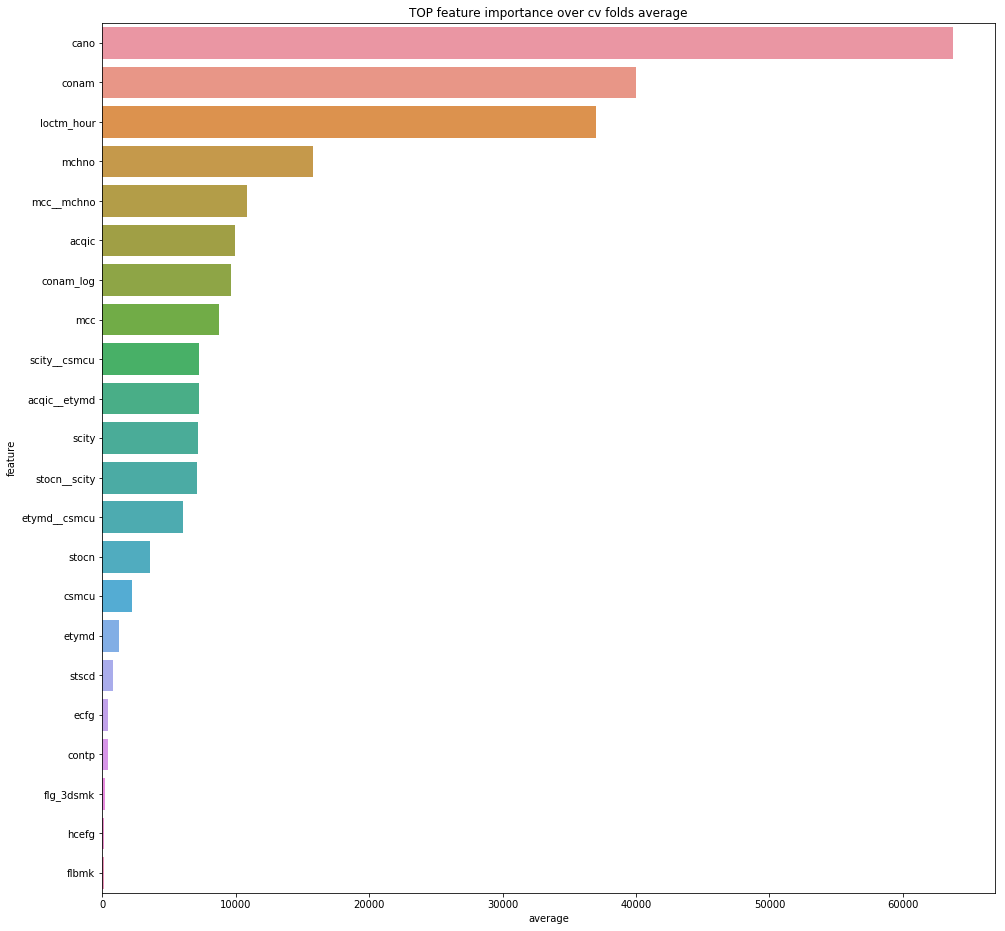

In [51]:
feature_importances['average'] = feature_importances.mean(axis=1)

plt.figure(figsize=(16, 16))
sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(30), x='average', y='feature')
plt.title('TOP feature importance over cv folds average');

In [43]:
# 结果保存
threshold = 0.5
predictions = [int(item>threshold) for  item in predictions]
sampleSubmission = pd.read_csv('submission_test_sample.csv')
sampleSubmission['fraud_ind'] = predictions
sampleSubmission.to_csv('submission_test.csv',index = None)

In [ ]:
threshold = 0.5
y_pre = [int(item>threshold) for  item in pred]
print( "  auc = ", roc_auc_score(y_valid_df, y_pre))
print( "  f1 = ", f1_score(y_valid_df, y_pre))
print( "  confusion_matrix = \r\n", confusion_matrix(y_valid_df, y_pre) )
#predictions += clf.predict(X_test) / splits